# Introduction to Neural Networks

In [1]:
import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

## The MNIST dataset
- x is for the inputs (images of handwritten digits)
- y is for the labels or outputs (digits 0-9)

The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


In [5]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [6]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [7]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [8]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

# Homework

1. Compare the quality of your model when using different:
 - batch sizes, 
 - learning rates,
 - activation functions.

2. Bonus: What is a learning rate scheduler?

### 1) Comparing with different hyperparameters
#### a) batch sizes

In [9]:
batch_sizes = [32,64,128,256]

train_batch_acc = []
val_batch_acc = []

for batch_size in batch_sizes:
    print('batch size:', batch_size)
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    train_batch_acc.append(train_acc_all)
    val_batch_acc.append(train_acc_all)

batch size: 32
Epoch 0: training loss: 0.28356077047685785, accuracy: 91.77916666666667
Epoch 0: val. loss: 0.27739497922857603, val. accuracy: 91.49166666666667
Epoch 1: training loss: 0.18172809724944333, accuracy: 94.65
Epoch 1: val. loss: 0.18495912621170282, val. accuracy: 94.45833333333333
Epoch 2: training loss: 0.14275345154075572, accuracy: 95.77708333333334
Epoch 2: val. loss: 0.15164302614082892, val. accuracy: 95.5
Epoch 3: training loss: 0.11973537928673128, accuracy: 96.4125
Epoch 3: val. loss: 0.1339114011960725, val. accuracy: 95.86666666666666
Epoch 4: training loss: 0.09593395648229246, accuracy: 97.2
Epoch 4: val. loss: 0.11350669730454684, val. accuracy: 96.43333333333334
batch size: 64
Epoch 0: training loss: 0.39086880228916804, accuracy: 88.79791666666667
Epoch 0: val. loss: 0.3848964795470238, val. accuracy: 88.63333333333333
Epoch 1: training loss: 0.25572829791903495, accuracy: 92.65208333333334
Epoch 1: val. loss: 0.2540143196807897, val. accuracy: 92.1166666

From the batch sizes,32,64,128, and 256; 32 had the best accuracy.

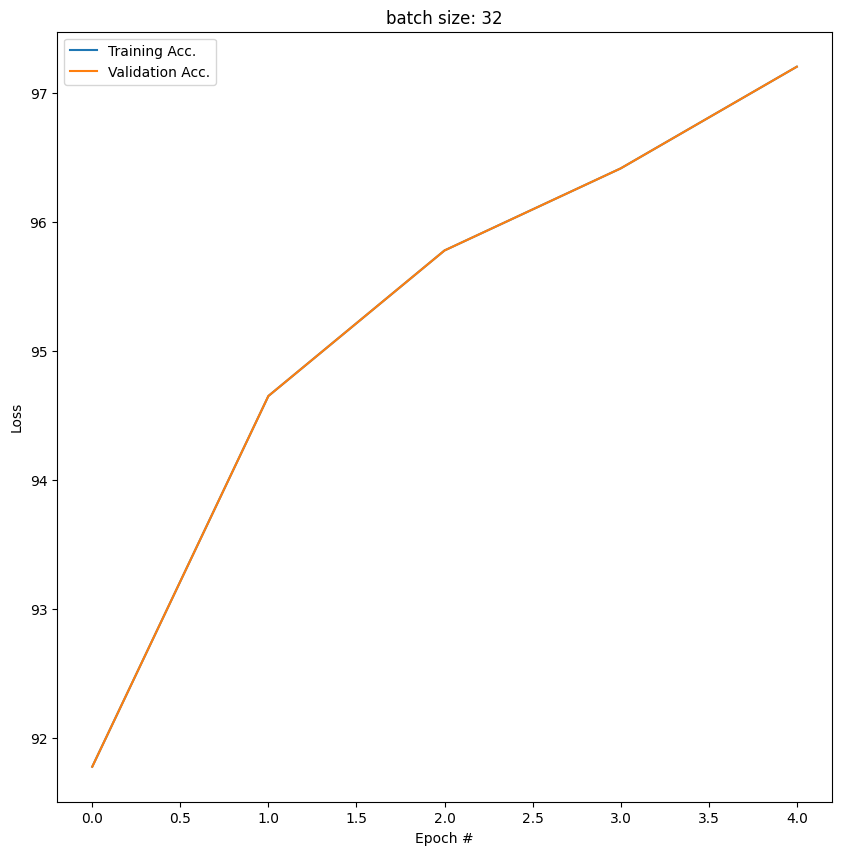

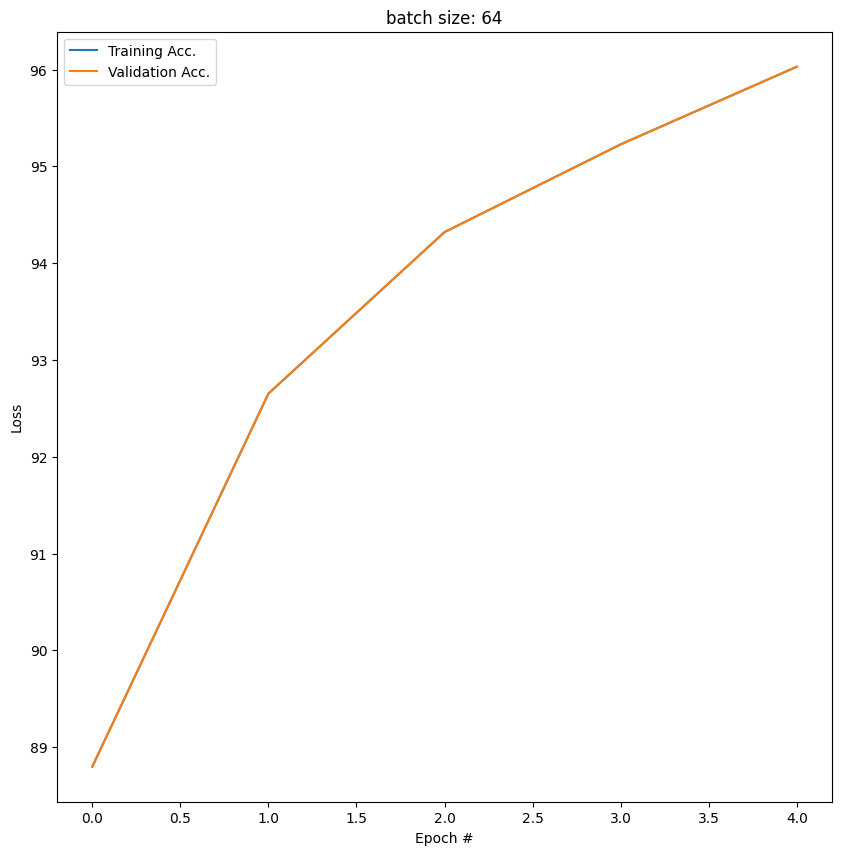

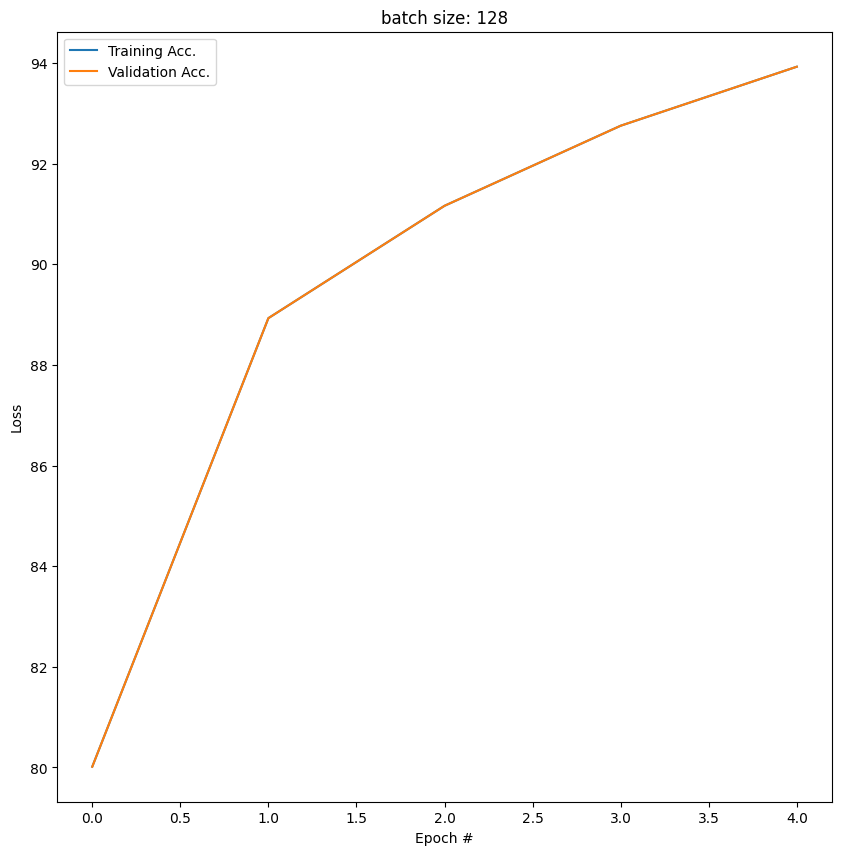

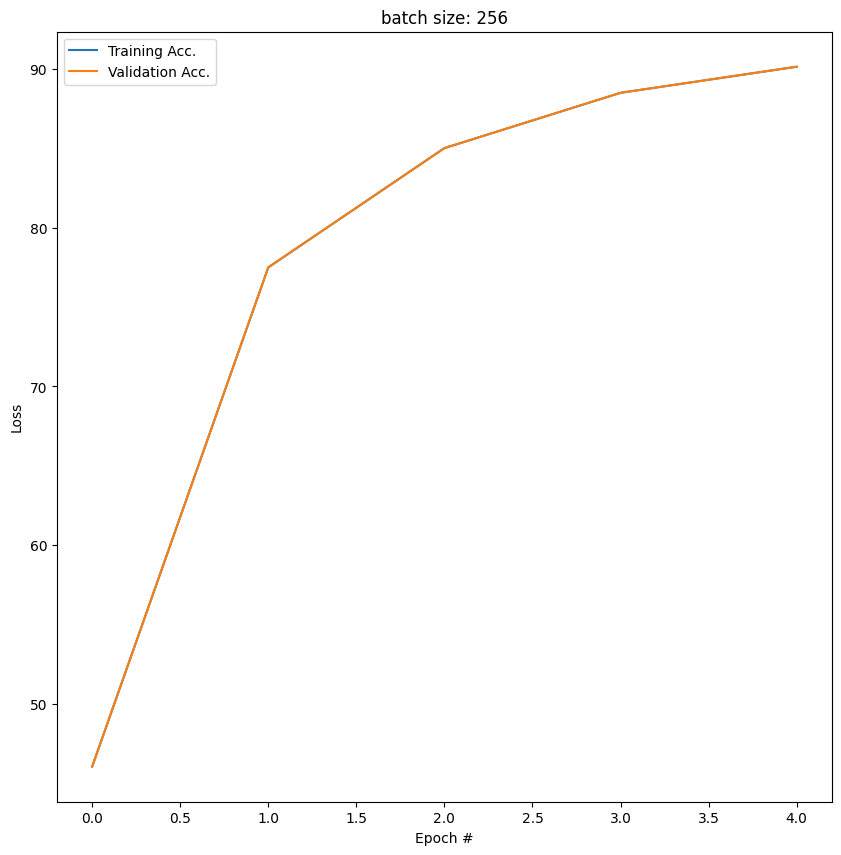

In [10]:
for j, batch_size in enumerate(batch_sizes):
    train_acc_all = train_batch_acc[j]
    val_acc_all = val_batch_acc[j]
    pltsize=1
    plt.figure(figsize=(10*pltsize, 10 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.')
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('batch size: '+str(batch_size))
    plt.show()

#### b) learning rates

In [12]:
lrs = [0.5, 0.05, 0.005]

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)


train_batch_acc = []
val_batch_acc = []

for lr in lrs:
    print('learning rate:', lr)
    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=lr)

    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    train_batch_acc.append(train_acc_all)
    val_batch_acc.append(train_acc_all)

learning rate: 0.5
Epoch 0: training loss: 0.47183575824896495, accuracy: 85.00833333333333
Epoch 0: val. loss: 0.4669034160832141, val. accuracy: 84.975
Epoch 1: training loss: 0.329281822403272, accuracy: 89.94375
Epoch 1: val. loss: 0.3248171034328481, val. accuracy: 89.9
Epoch 2: training loss: 0.23634155015150707, accuracy: 92.92708333333334
Epoch 2: val. loss: 0.23690121066063008, val. accuracy: 92.94166666666666
Epoch 3: training loss: 0.21012130934000015, accuracy: 93.73125
Epoch 3: val. loss: 0.2163625844615571, val. accuracy: 93.38333333333333
Epoch 4: training loss: 0.20681872113545735, accuracy: 93.73541666666667
Epoch 4: val. loss: 0.21968715637922287, val. accuracy: 93.40833333333333
learning rate: 0.05
Epoch 0: training loss: 0.8687532947858174, accuracy: 74.8125
Epoch 0: val. loss: 0.8628727584443194, val. accuracy: 74.325
Epoch 1: training loss: 0.41926053138573965, accuracy: 88.1625
Epoch 1: val. loss: 0.4110749110262445, val. accuracy: 88.08333333333334
Epoch 2: trai

From the learning rates, 0.5, 0.05, and 0.005; 0.05 had the best accuracy.

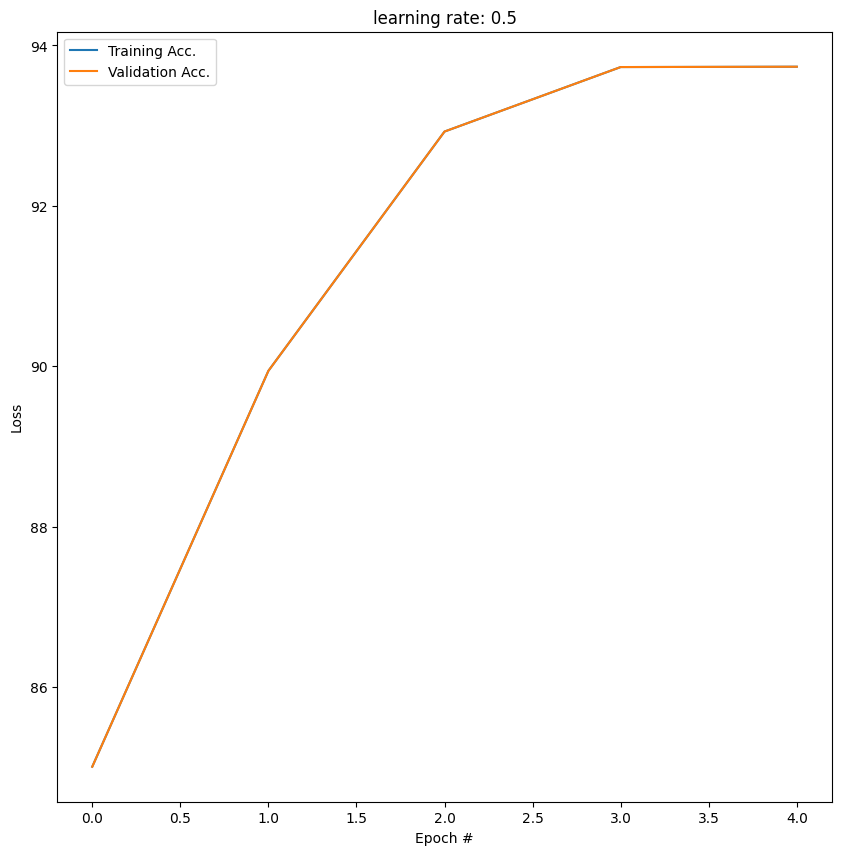

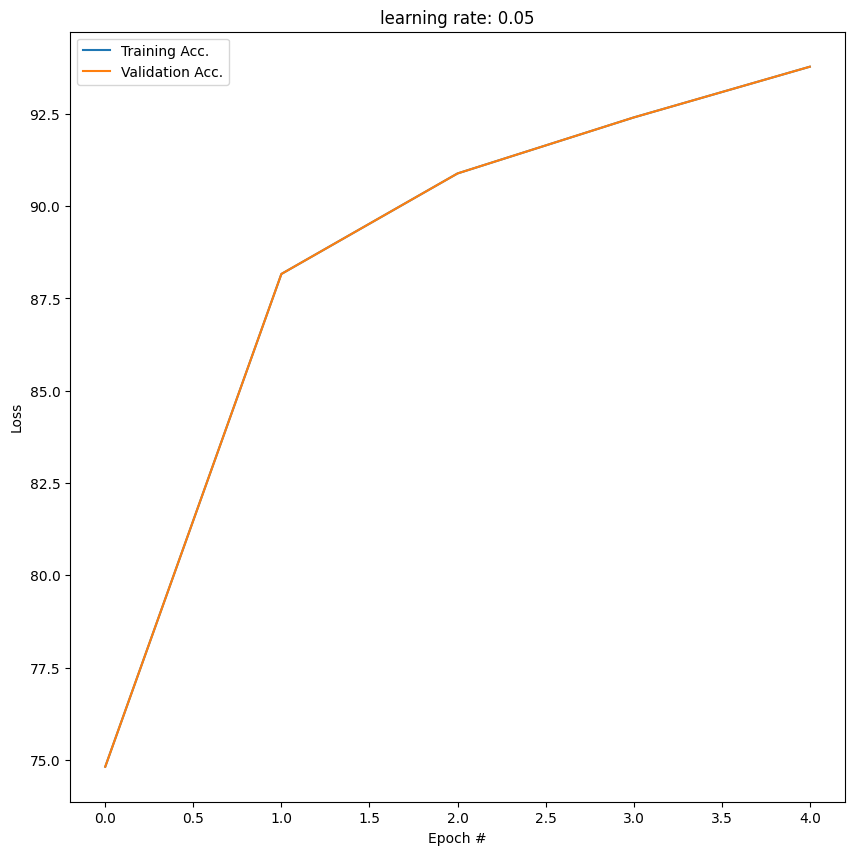

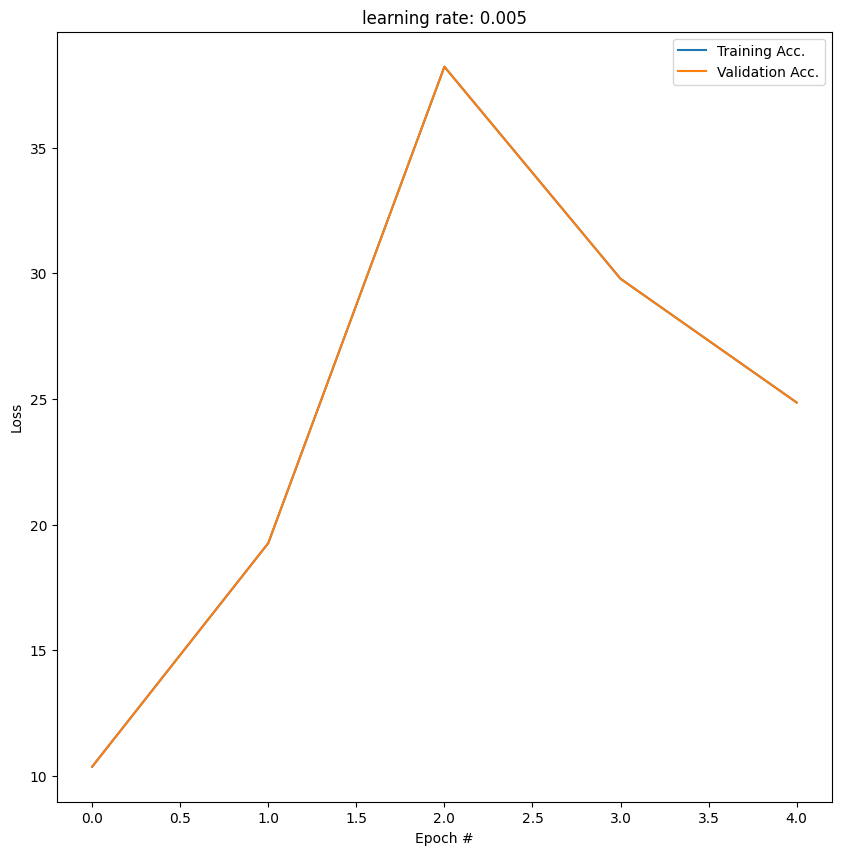

In [13]:
for j, lr in enumerate(lrs):
    train_acc_all = train_batch_acc[j]
    val_acc_all = val_batch_acc[j]
    pltsize=1
    plt.figure(figsize=(10*pltsize, 10 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.')
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('learning rate: '+str(lr))
    plt.show()

#### c) activation functions

In [14]:
class NonlinearClassifier_ELU(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
    
class NonlinearClassifier_tanh(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [15]:
models = [NonlinearClassifier(),NonlinearClassifier_ELU(), NonlinearClassifier_tanh()]

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)


train_batch_acc = []
val_batch_acc = []

for model in models:
    nonlinear_model = model
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    train_batch_acc.append(train_acc_all)
    val_batch_acc.append(train_acc_all)

Epoch 0: training loss: 0.7267827275594075, accuracy: 78.07083333333334
Epoch 0: val. loss: 0.7221398810122875, val. accuracy: 77.64999999999999
Epoch 1: training loss: 0.4130734106302261, accuracy: 88.33541666666666
Epoch 1: val. loss: 0.4080840456993022, val. accuracy: 88.25
Epoch 2: training loss: 0.29762711040178935, accuracy: 91.43958333333333
Epoch 2: val. loss: 0.2927362855444563, val. accuracy: 91.34166666666667
Epoch 3: training loss: 0.24422083187103272, accuracy: 92.94583333333334
Epoch 3: val. loss: 0.24098204734160544, val. accuracy: 92.93333333333334
Epoch 4: training loss: 0.20722723988691966, accuracy: 93.93958333333333
Epoch 4: val. loss: 0.2077248475336014, val. accuracy: 93.75
Epoch 0: training loss: 0.5044790935516358, accuracy: 85.425
Epoch 0: val. loss: 0.495542953940148, val. accuracy: 85.39166666666667
Epoch 1: training loss: 0.3471371725400289, accuracy: 90.07708333333333
Epoch 1: val. loss: 0.33551564479761936, val. accuracy: 89.86666666666666
Epoch 2: trainin

The ReLU activation function is performing better than ELU and tanh.

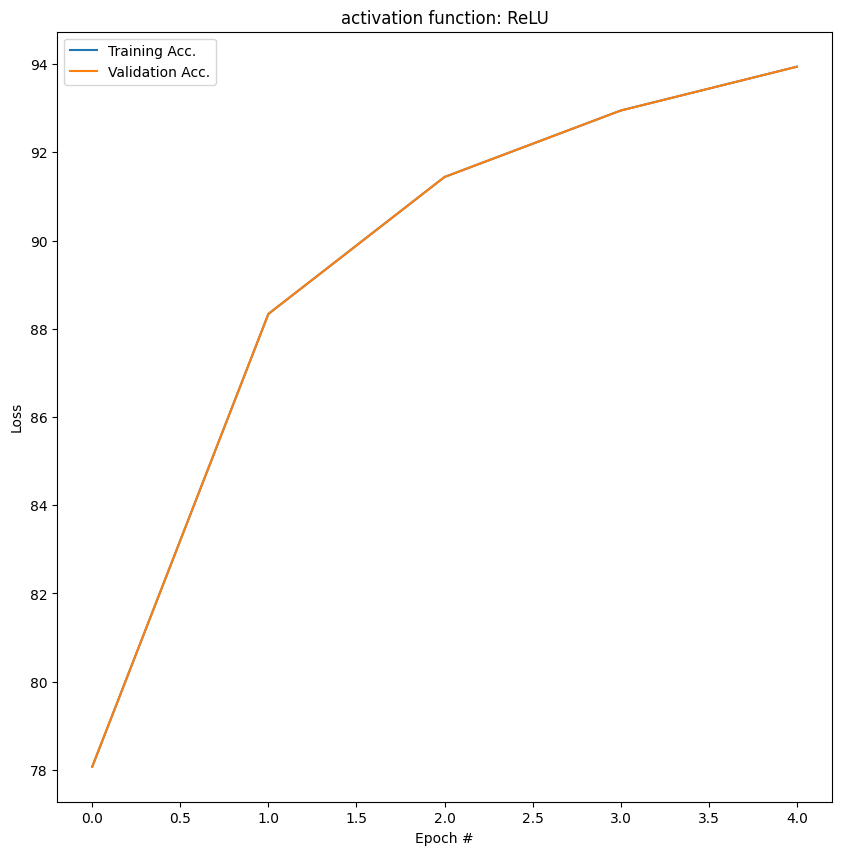

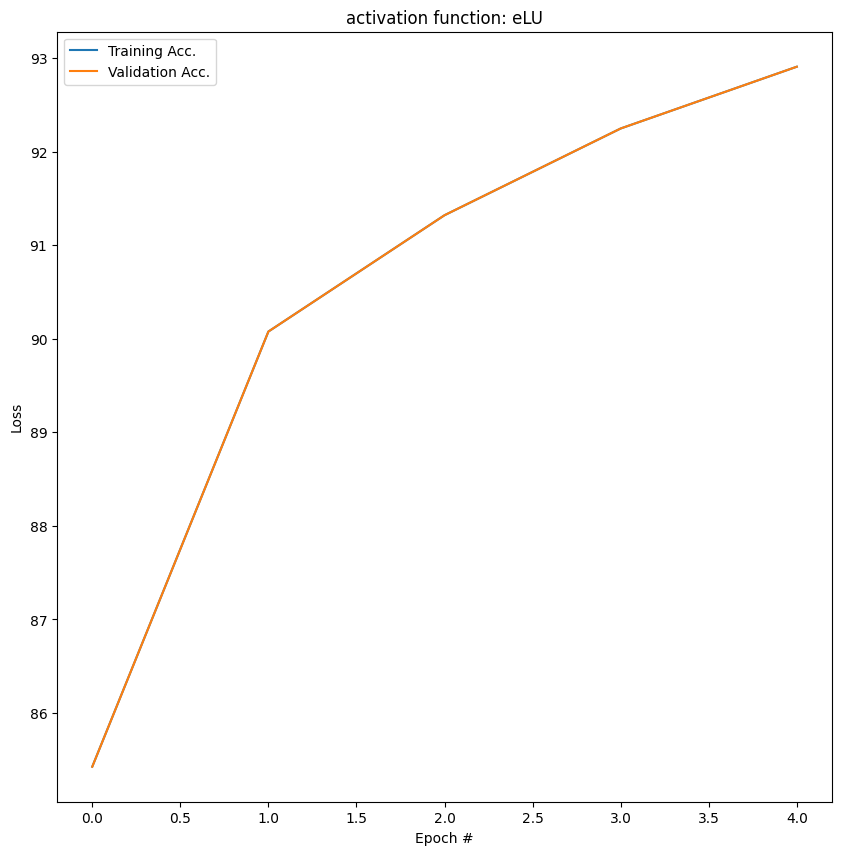

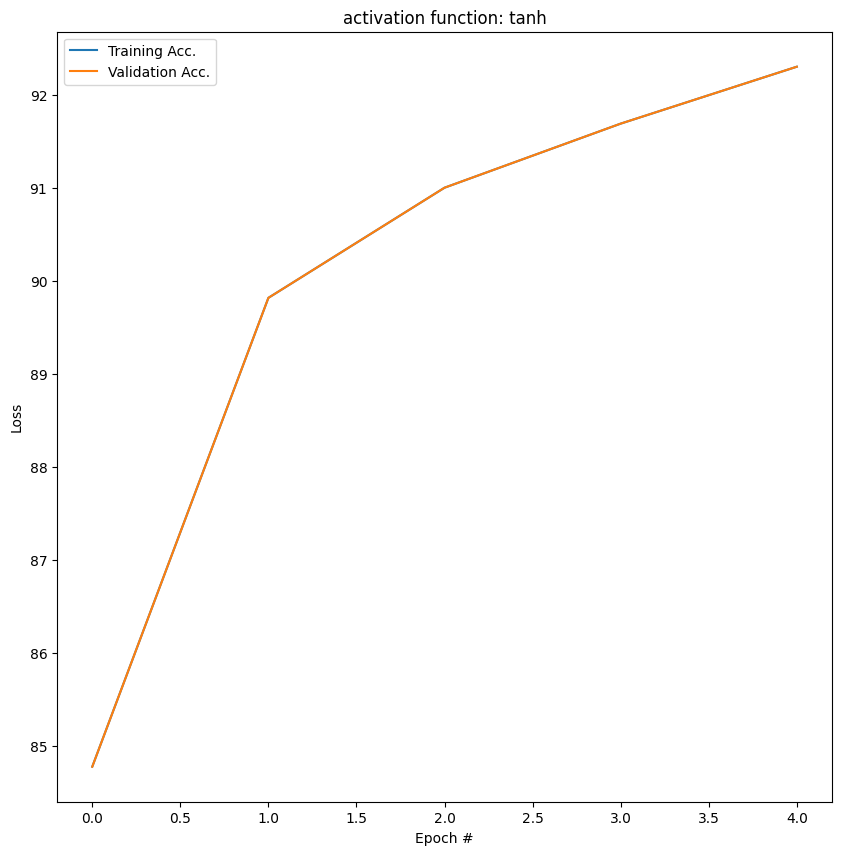

In [16]:
for j, activation in enumerate(['ReLU','eLU','tanh']):
    train_acc_all = train_batch_acc[j]
    val_acc_all = val_batch_acc[j]
    pltsize=1
    plt.figure(figsize=(10*pltsize, 10 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.')
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('activation function: '+activation)
    plt.show()

### 2) Learning rate scheduler

A learning rate scheduler shrinks the learning rate when some condition is met.

For example,
- torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma) decreases the learning rate by a factor of gamma every step_size epochs

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html


- torch.optim.lr.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, threshold=0.0001) decreases the learning rate by a factor of _factor_ if there is no improvement after _patience_ number of epochs, where _threshold_ defines the threshold for considering the new optimum values.

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
